In [1]:
# News Category Dataset
# https://www.kaggle.com/datasets/rmisra/news-category-dataset
# ここからデータセットをダウンロードすると、archive.zipがダウンロードされる
# それをnews_category_dataset_kaggle.zipとしてMyDriveに保存
!ls /content/drive/MyDrive/ | grep news
!cp /content/drive/MyDrive/news_category_dataset_kaggle.zip .
!unzip news_category_dataset_kaggle.zip

news_category_dataset_kaggle.zip
Archive:  news_category_dataset_kaggle.zip
replace News_Category_Dataset_v3.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
# データセットの読み込み
data_list = []
# ファイルを開く
with open('/content/News_Category_Dataset_v3.json', 'r') as file:
    # ファイルの各行に対してループ処理
    for line in file:
        # lineから改行を排除し、str -> dict 変換
        line = eval(line.replace("\n", ""))
        # テキスト配列に、ニュースの見出しと概要を連結した文章を追加
        data_list.append({
            "text": line["headline"] + " " + line["short_description"],
            "category": line["category"],
        })
print(data_list[:10])
print(str(len(data_list)) + " documents were loaded.")

[{'text': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.', 'category': 'U.S. NEWS'}, {'text': "American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.", 'category': 'U.S. NEWS'}, {'text': '23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23) "Until you have a dog you don\'t understand what could be eaten."', 'category': 'COMEDY'}, {'text': 'The Funniest Tweets From Parents This Week (Sept. 17-23) "Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."', 'category': 'PARENTING'}, {'text': 'Woman

In [3]:
!pip install nltk
import nltk
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport
nltk.download('stopwords')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# 前処理
import re
# 前処理関数作成
def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    word = re.sub(r'[.,!?\'"(){}[\]:’‘“”#*]', "", word)
    # 数字除去
    word = re.sub(r'[0-9]+', "", word)
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma

def preprocess_document(document, en_stop):
    # ここではサンプルコードと違い、documentは文章 -> 単語分割する必要あり
    split_doc = document["text"].split(" ")
    processed=[preprocess_word(w, en_stop) for w in split_doc]
    # None除去
    processed=[w for w in processed if w is not None]
    # ストップワードしか含まれていないデータを除去
    pre_doc = " ".join(processed)
    if pre_doc == "":
        return None
    else:
        ret_doc = {
            "text": pre_doc,
            "category": document["category"]
        }
        return ret_doc

def preprocess_documents(documents, en_stop):
    result_list = []
    for document in documents:
        pre_doc = preprocess_document(document, en_stop) 
        if pre_doc is not None:
            result_list.append(pre_doc)
    return result_list

# stop word list 作成
# ntlk + simbols
en_stop = nltk.corpus.stopwords.words('english')
en_stop= (["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]
+en_stop)

# 前処理をtext_listの文章に対して実行
preprocessed_data = preprocess_documents(data_list, en_stop)
print(preprocessed_data[:2])
print(len(preprocessed_data))

[{'text': ' million american roll sleeve omicron-targeted covid booster health expert say early predict whether demand would match  million dose new booster us order fall', 'category': 'U.S. NEWS'}, {'text': 'american airline flyer charge ban life punch flight attendant video subdue passenger crew flee back aircraft confrontation accord us attorney office los angeles', 'category': 'U.S. NEWS'}]
209519


In [5]:
# ここからLDA関連処理
!pip install gensim
!pip install pyLDAvis
import gensim
from gensim import corpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#documentを，gensim LDAが読み込めるデータ構造にする
preprocessed_text = [x["text"].split() for x in preprocessed_data]
#辞書の作成
dictionary = corpora.Dictionary(preprocessed_text)
#コーパスの作成
corpus_ = [dictionary.doc2bow(doc) for doc in preprocessed_text]

#Dictionary:gensimにおける辞書クラス
#token2id属性には単語と辞書IDとの対応が格納される
# print(dictionary.token2id)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
category_labels = list(set([x["category"] for x in preprocessed_data]))
class_num = len(category_labels)
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=class_num,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

In [8]:
#(トピックID, 当該トピックにおける単語とそのprobability)  ※　のうち、上位num_words位 
print("There are " + str(class_num) + " topics.")
topics = ldamodel.print_topics(num_topics=-1, num_words=10)
print(len(topics))
for topic in topics:
    print(topic)

There are 42 topics.
42
(0, '0.389*"photo" + 0.022*"hope" + 0.018*"image" + 0.018*"remember" + 0.017*"street" + 0.016*"see" + 0.015*"wrong" + 0.014*"talks" + 0.013*"artist" + 0.012*"jennifer"')
(1, '0.023*"since" + 0.022*"three" + 0.020*"country" + 0.019*"us" + 0.017*"people" + 0.017*"hot" + 0.017*"percent" + 0.017*"disease" + 0.016*"american" + 0.014*"cause"')
(2, '0.040*"open" + 0.031*"exercise" + 0.027*"test" + 0.026*"however" + 0.023*"sense" + 0.023*"cool" + 0.021*"decide" + 0.019*"right" + 0.017*"south" + 0.017*"technology"')
(3, '0.068*"youre" + 0.042*"sleep" + 0.039*"healthy" + 0.037*"learn" + 0.031*"around" + 0.030*"le" + 0.028*"happy" + 0.027*"stress" + 0.024*"world" + 0.022*"offer"')
(4, '0.060*"tip" + 0.051*"girl" + 0.037*"weve" + 0.036*"hair" + 0.033*"daughter" + 0.021*"note" + 0.019*"team" + 0.018*"especially" + 0.018*"understand" + 0.017*"attention"')
(5, '0.052*"health" + 0.029*"always" + 0.028*"$" + 0.027*"long" + 0.024*"money" + 0.023*"care" + 0.020*"million" + 0.018*"

In [9]:
# 10個の⽂書を選んで，それぞれの⽂書におけるトピック分布を⽰せ
#[(当該documentにおけるトピックIDとそのprobability　)]　 ※　のうち、minimum_probabilityの値を超えるもの

for n,item in enumerate(corpus_[:10]):
    print("document ID "+str(n)+":" ,end="")
    print(ldamodel.get_document_topics(item))

document ID 0:[(3, 0.17330936), (5, 0.15403579), (7, 0.043902896), (15, 0.16822527), (18, 0.04453036), (20, 0.0468614), (24, 0.12313655), (28, 0.051362272), (38, 0.063624874)]
document ID 1:[(1, 0.08596077), (8, 0.0991896), (24, 0.25865778), (27, 0.19573703), (30, 0.04295083), (31, 0.07977036), (39, 0.071742594), (41, 0.040898375)]
document ID 2:[(4, 0.07418331), (11, 0.083327085), (18, 0.2199205), (21, 0.16496366), (40, 0.21414316)]
document ID 3:[(2, 0.08989429), (3, 0.2741104), (21, 0.1553187), (24, 0.054431237), (40, 0.24308494)]
document ID 4:[(5, 0.123825476), (8, 0.091543026), (10, 0.042577174), (11, 0.0976453), (16, 0.043827083), (18, 0.04650592), (22, 0.04256003), (28, 0.043071073), (29, 0.09246121), (30, 0.08402051), (36, 0.049180005), (37, 0.0423569), (39, 0.047756605), (41, 0.04564005)]
document ID 5:[(1, 0.19426179), (2, 0.15832305), (10, 0.04029732), (11, 0.0667268), (16, 0.040620983), (18, 0.15497594), (25, 0.050664242), (34, 0.04049883), (41, 0.1322904)]
document ID 6:[

In [10]:
# 文書の正解ラベル
categories = [x["category"] for x in preprocessed_data]

In [11]:
n=0

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(preprocessed_data[n]["text"])

[(3, 0.17323774), (5, 0.15396582), (7, 0.04390165), (15, 0.16820572), (18, 0.04452787), (20, 0.046855565), (24, 0.12349982), (28, 0.051348425), (38, 0.06344618)]
U.S. NEWS
 million american roll sleeve omicron-targeted covid booster health expert say early predict whether demand would match  million dose new booster us order fall


In [12]:
# ここから可視化
#import pyLDAvis.gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [13]:
#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# 何番目のカテゴリ（LDAが予測したトピック）が、元のデータセットのどのカテゴリに属しているのか調べる
from tqdm import tqdm
def lda_topic_category(ldamodel):
    lda_num_topics = ldamodel.num_topics

    # トピック番号 - 1の位置に、元データのカテゴリラベル一覧を入れる
    lda_topic_items =  {}
    for i in range(lda_num_topics):
        lda_topic_items[i] = []

    for i, data in tqdm(enumerate(preprocessed_data)):
        text = data["text"]
        category = data["category"]
        corpus = corpus_[i]

        lda_topics = ldamodel.get_document_topics(corpus)
        max_topic = max(lda_topics, key=lambda x: x[1])
        lda_topic_id = max_topic[0]
        lda_topic_items[lda_topic_id].append(category)
    return lda_topic_items
lda_topic_items = lda_topic_category(ldamodel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
209519it [01:07, 3092.97it/s]


In [15]:
# ldaのtopic id がnの文書のカテゴリ分布
# ヒストグラム作成
import matplotlib.pyplot as plt
from collections import Counter

def plot_categories_in(lda_topic_items: dict,  lda_id: int):
    category_counts = {}
    lda_categories = lda_topic_items[lda_id]
    for category in lda_categories:
        if category in category_counts.keys():
            category_counts[category] += 1
        else:
            category_counts[category] = 1

    # カテゴリと個数のリスト
    categories_list = list(category_counts.keys())
    count_list = list(category_counts.values())

    # ヒストグラム描画
    plt.bar(categories_list, count_list)
    plt.xticks(rotation=90)
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.title('Category Histogram')
    plt.show()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


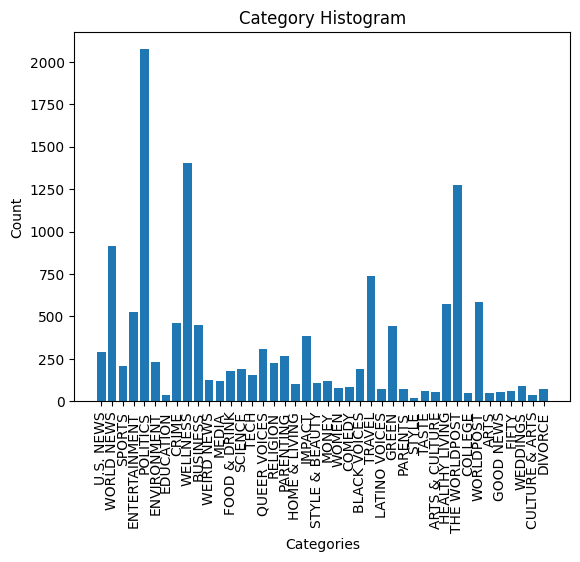

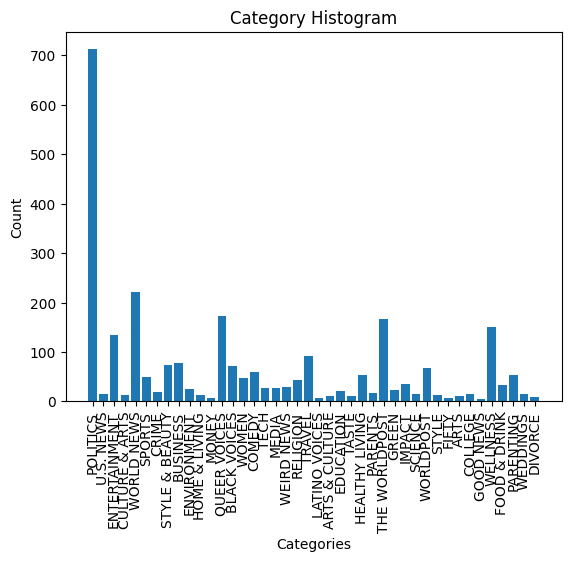

In [16]:
plot_categories_in(lda_topic_items, 1)
plot_categories_in(lda_topic_items, 2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


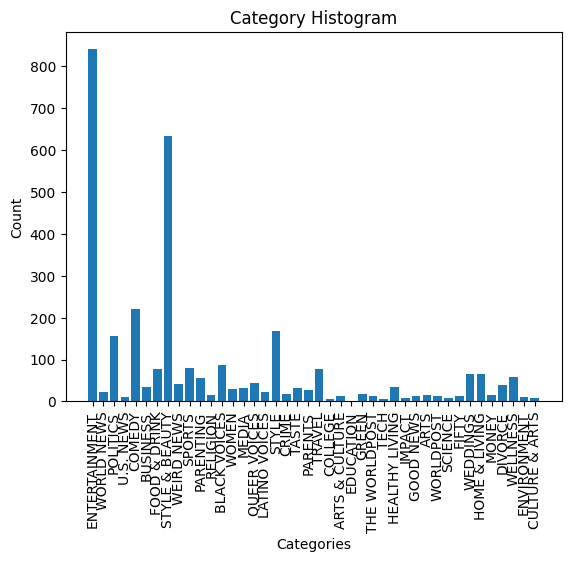

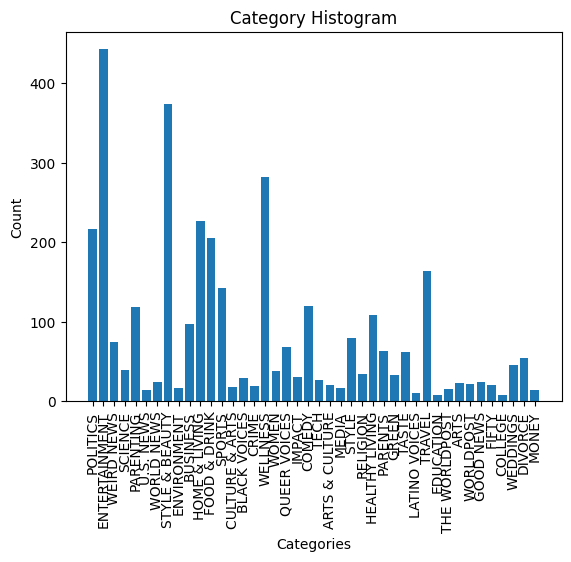

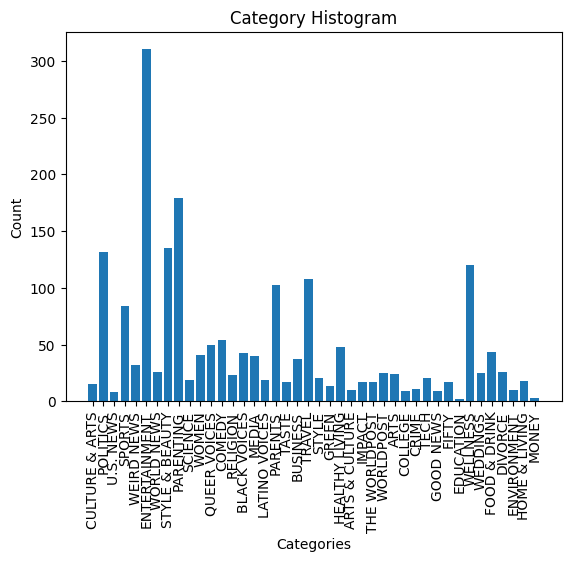

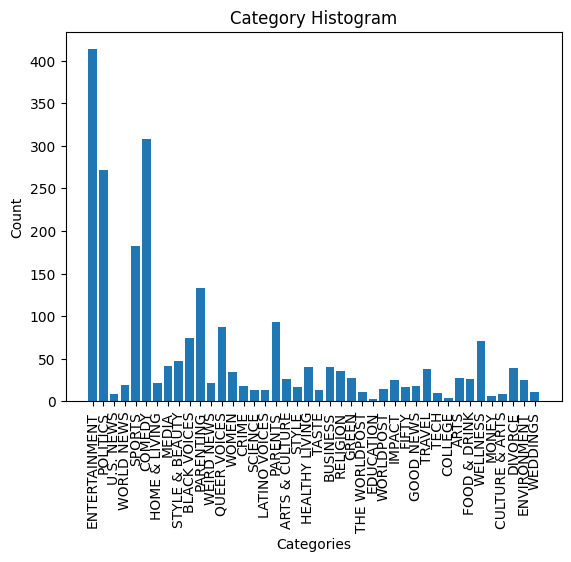

In [31]:
plot_categories_in(lda_topic_items, 34)
plot_categories_in(lda_topic_items, 19)
plot_categories_in(lda_topic_items, 32)
plot_categories_in(lda_topic_items, 36)

In [17]:
# num_topicsを元データセットのカテゴリ数の半分にしてみる
ldamodel_half = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=int(class_num / 2),
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
lda_display_half = pyLDAvis.gensim_models.prepare(ldamodel_half, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display_half)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
209519it [01:20, 2617.08it/s]


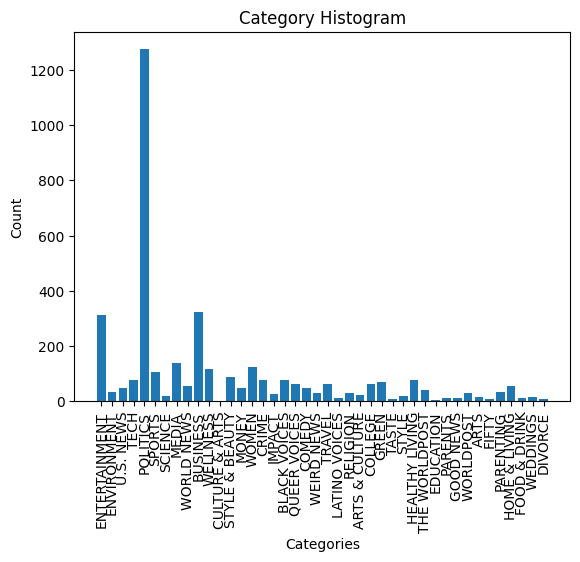

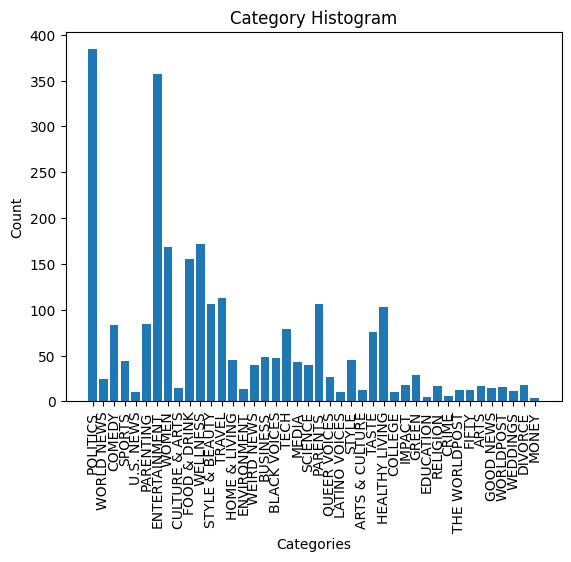

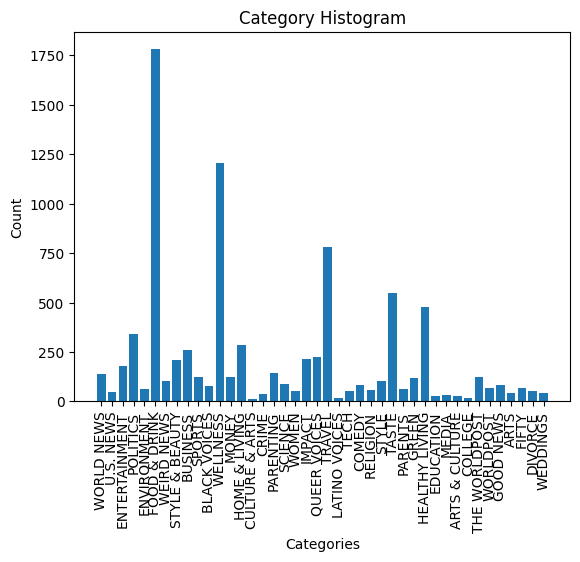

In [23]:
# LDAの分類1に属するニュースのカテゴリ
ldahalf_topic_items = lda_topic_category(ldamodel_half)
plot_categories_in(ldahalf_topic_items, 7)
plot_categories_in(ldahalf_topic_items, 14)
plot_categories_in(ldahalf_topic_items, 16)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


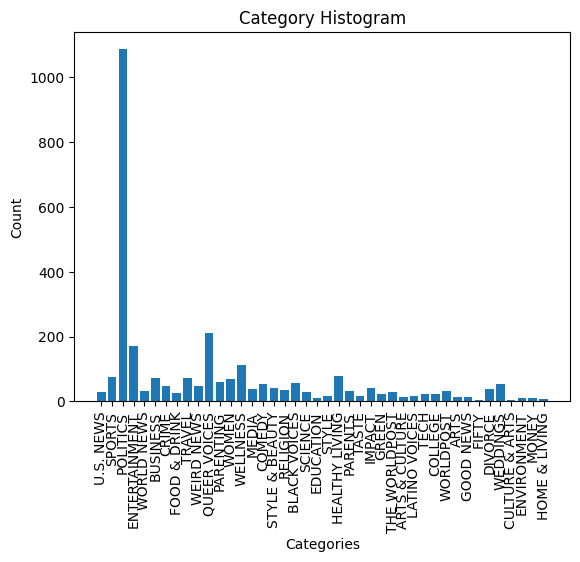

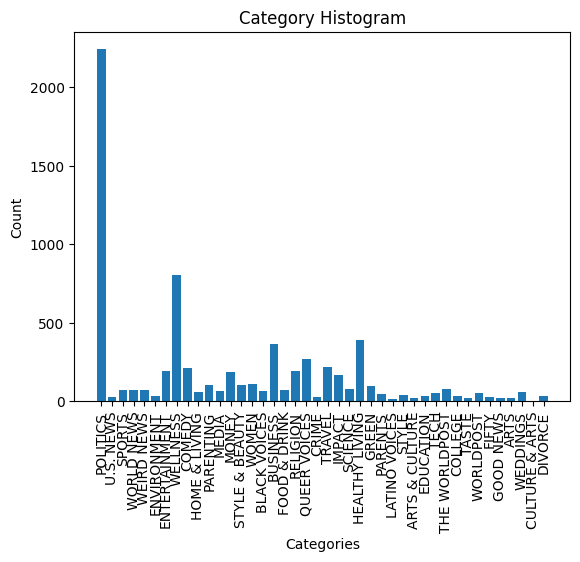

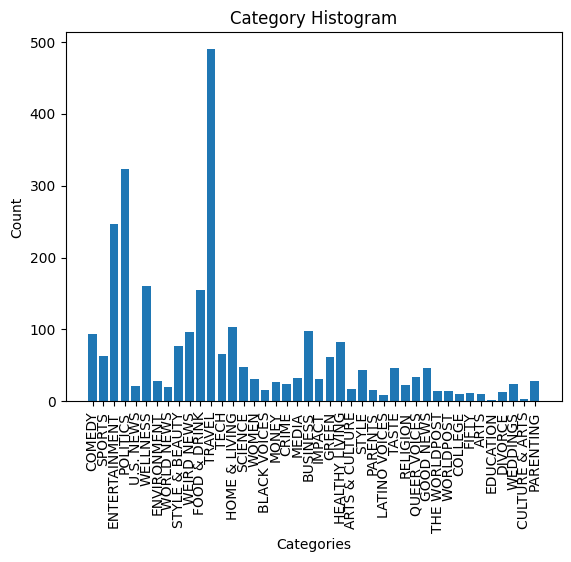

In [25]:
plot_categories_in(ldahalf_topic_items, 1)
plot_categories_in(ldahalf_topic_items, 2)
plot_categories_in(ldahalf_topic_items, 18)

In [20]:
# num_topicsを元データセットのカテゴリ数の２倍にしてみる
ldamodel_double = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=int(class_num * 2),
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
lda_display_double = pyLDAvis.gensim_models.prepare(ldamodel_double, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display_double)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
209519it [01:32, 2265.34it/s]


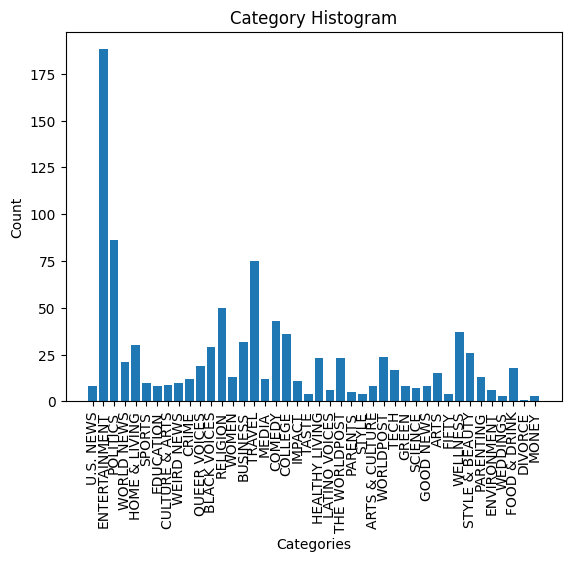

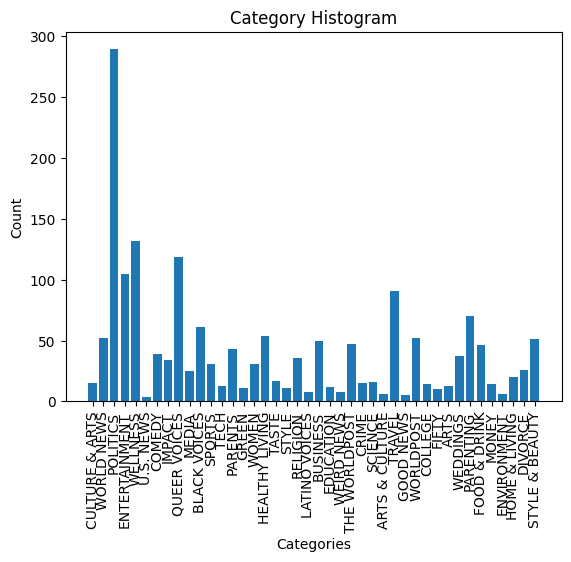

In [22]:
# LDAの分類1に属するニュースのカテゴリ
ldadouble_topic_items = lda_topic_category(ldamodel_double)
plot_categories_in(ldadouble_topic_items, 1)
plot_categories_in(ldadouble_topic_items, 2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


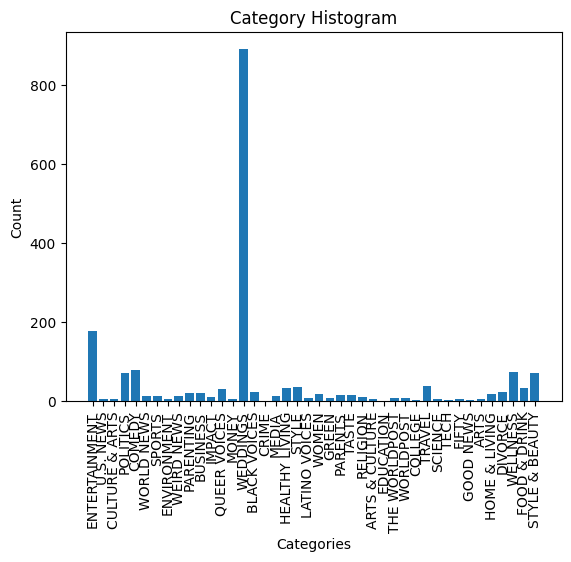

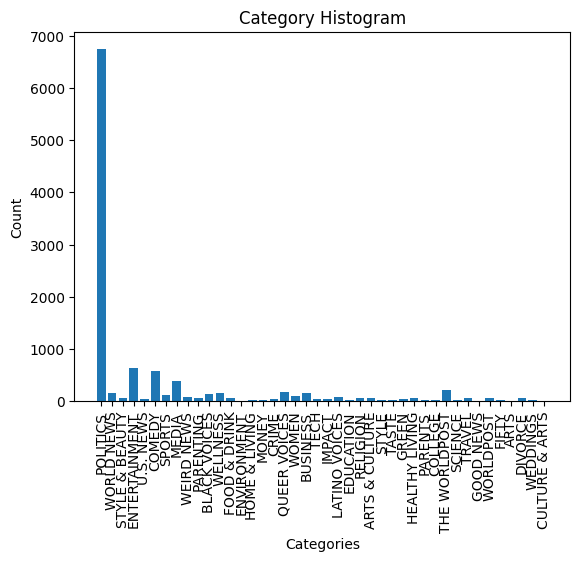

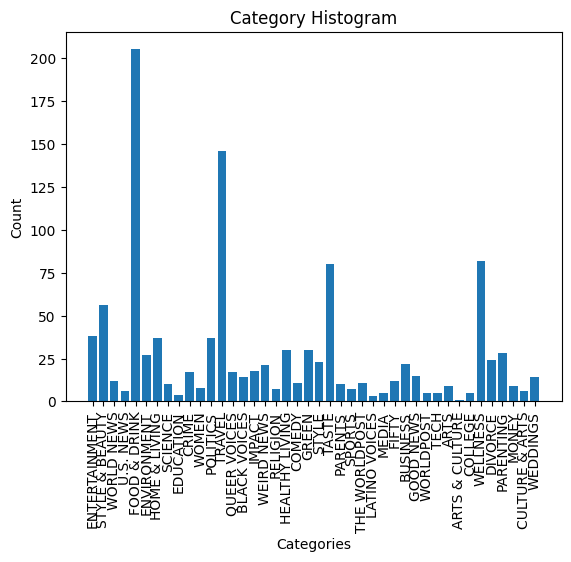

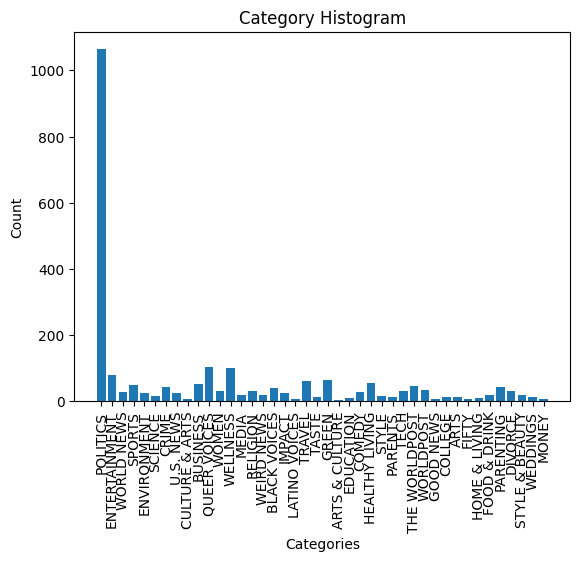

In [28]:
plot_categories_in(ldadouble_topic_items, 49)
plot_categories_in(ldadouble_topic_items, 14)
plot_categories_in(ldadouble_topic_items, 15)
plot_categories_in(ldadouble_topic_items, 51)